# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import graphviz
from datetime import date
import time
import pyreadr

import os
import math
from math import sqrt

# Tensorflow and Keras
from keras.layers import Concatenate, Input, LSTM, Dense
from keras.layers import Dropout, Flatten, Reshape, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.activations import softmax
from keras.callbacks import EarlyStopping

import tensorflow as tf
from keras import backend as K

print(tf.__version__) # 2.6.0
print(tf.config.list_physical_devices('GPU'))

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data

In [2]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
scaler_MG = MinMaxScaler(feature_range = (0, 1)).fit(MG)
MG = scaler_MG.transform(MG)
tileMG = np.tile(MG, 214)

# Transform Genotype into ClusterID, and stack with MG
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# MG = np.hstack([MG, K])

# Standardization prcess
scaler_x0 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
# X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6, tileMG])

Y = Y.reshape(-1,1)
scaler_Y = MinMaxScaler(feature_range = (0, 1)).fit(Y)
Y = scaler_Y.transform(Y)

# Trancation
# X = X[:,np.arange(0,214,7),:] 

#####################################
# Load training and validation data #
#####################################
# 10% is test, 10% is val, 80% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.2, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

MG_train, MG_val = train_test_split(MG, test_size=0.2, shuffle=True, random_state=888)
MG_val, MG_test = train_test_split(MG_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''

# Transform into tensor
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

MG_train = MG_train.astype('float')
MG_val = MG_val.astype('float')
MG_test = MG_test.astype('float')

In [3]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(93028, 214, 8)
(74422, 214, 8)
(9303, 214, 8)
(9303, 214, 8)


# CNN LSTM
X (weather data) is not treated as indepedent inputs

# Define function

In [4]:
Tx = X_train.shape[1] # 214 days
var_ts = X_train.shape[2] # Weather(7), MG
var_concat = 1 # MG

kernel_size1 = 7
kernel_size2 = 3

filters1 = 32
filters2 = 64

h_s = 128   # {32, 64, 96, 128, 256}
dropout = 0.2  
batch_size = 512  
epochs = 500  # 100
lr_rate = 0.001   # (0.001, 3e-4, 5e-4)
con_dim = 2   # (1, 2, 4, 8, 16) # Reduction in dimension of the temporal context to con_dim before concat with MG, Cluster

# Model Architecture (LSTM)

In [5]:
concatenator = Concatenate(axis=-1)

def model(Tx, var_ts, var_concat, kernel_size1, kernel_size2, filters1, filters2, h_s, dropout):
    
    # Tx : Number of input timesteps
    # var_ts: Number of input variables
    # h_s: Hidden State Dimensions for Encoder, Decoder
    encoder_input = Input(shape = (Tx, var_ts))   # (None, 30, 9)
    mg_cluster_input = Input(shape = (var_concat, ))   # (None, 2)
    
    
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=1, padding="causal", activation="relu")(encoder_input)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv1 = Conv1D(filters=filters2, kernel_size=kernel_size2, strides=1, padding="causal", activation="relu")(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
#     conv1 = Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu")(conv1)
#     conv1 = MaxPooling1D(pool_size=2)(conv1)
    
    # Encoder LSTM
    lstm_1, state_h, state_c = LSTM(h_s, return_state=True, return_sequences=True)(conv1)
    lstm_1 = Dropout (dropout)(lstm_1)     # (None, 30, 128)
    
    lstm_2, state_h, state_c = LSTM(h_s, return_state=True, return_sequences=False)(lstm_1)
    lstm_2 = Dropout (dropout)(lstm_2)     # (None, 128)
    
    # Dimension Reduction
    lstm_2 = Dense(con_dim, activation = "relu")(lstm_2)   # (None, 1)
    
    # Concatenate
    context = concatenator([lstm_2, mg_cluster_input])   # (None, 3)
    
    # FC Layer
    yhat = Dense (1, activation = "linear")(context)   # (None, 1)
        
    pred_model = Model([encoder_input, mg_cluster_input], yhat)   # Prediction Model
        
    return pred_model

# Visualiza model architechture

In [6]:
# Model Summary
pred_model = model(Tx, var_ts, var_concat, kernel_size1, kernel_size2, filters1, filters2, h_s, dropout)
pred_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 214, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 214, 32)      1824        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 107, 32)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 107, 64)      6208        max_pooling1d[0][0]              
______________________________________________________________________________________________

## Train process

In [7]:
# Train Model
tf.random.set_seed(12345) # For reproducibility

pred_model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=lr_rate)) 

early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.0,
                            patience=20,
)

hist = pred_model.fit ([X_train,MG_train], Y_train,
                       batch_size = batch_size,
                       epochs = epochs,
                       verbose = 2,
                       shuffle = True,
                       validation_data=([X_val, MG_val], Y_val),
                       callbacks=[early_stopping])

filepath = './model_keras/CNN_LSTM_BestKerasModel'
tf.keras.models.save_model(pred_model, filepath)

Epoch 1/500
146/146 - 38s - loss: 0.0564 - val_loss: 0.0472
Epoch 2/500
146/146 - 6s - loss: 0.0416 - val_loss: 0.0360
Epoch 3/500
146/146 - 6s - loss: 0.0325 - val_loss: 0.0290
Epoch 4/500
146/146 - 6s - loss: 0.0269 - val_loss: 0.0248
Epoch 5/500
146/146 - 6s - loss: 0.0235 - val_loss: 0.0225
Epoch 6/500
146/146 - 6s - loss: 0.0217 - val_loss: 0.0212
Epoch 7/500
146/146 - 7s - loss: 0.0208 - val_loss: 0.0206
Epoch 8/500
146/146 - 7s - loss: 0.0203 - val_loss: 0.0204
Epoch 9/500
146/146 - 6s - loss: 0.0202 - val_loss: 0.0203
Epoch 10/500
146/146 - 6s - loss: 0.0201 - val_loss: 0.0202
Epoch 11/500
146/146 - 6s - loss: 0.0201 - val_loss: 0.0202
Epoch 12/500
146/146 - 6s - loss: 0.0201 - val_loss: 0.0202
Epoch 13/500
146/146 - 6s - loss: 0.0200 - val_loss: 0.0202
Epoch 14/500
146/146 - 7s - loss: 0.0200 - val_loss: 0.0202
Epoch 15/500
146/146 - 7s - loss: 0.0200 - val_loss: 0.0203
Epoch 16/500
146/146 - 6s - loss: 0.0200 - val_loss: 0.0202
Epoch 17/500
146/146 - 6s - loss: 0.0201 - val_l

INFO:tensorflow:Assets written to: ./model_keras/CNN_LSTM_BestKerasModel\assets


INFO:tensorflow:Assets written to: ./model_keras/CNN_LSTM_BestKerasModel\assets


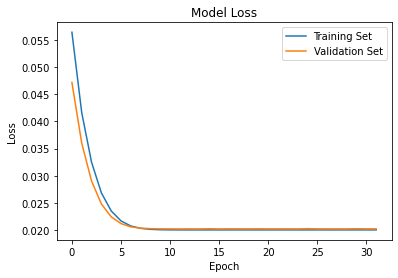

In [8]:
# Plot
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
# plt.savefig('%s/loss_plot.png'%(dir_))
# print("Saved loss plot to disk") 
# plt.close()

# Check the best model

Train


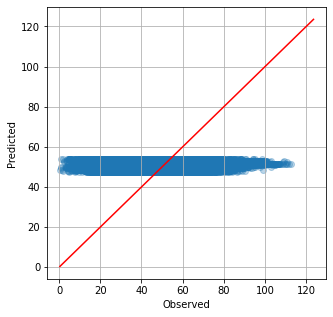

Validation


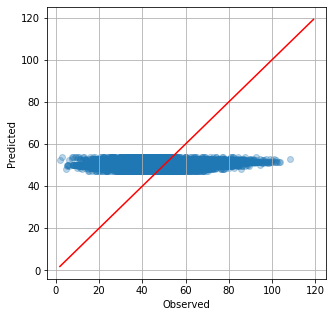

Test


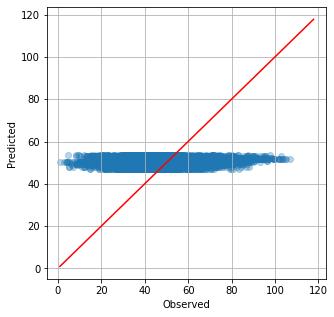

Train RMSE: 15.86
Train MAE: 12.69
Train R2: 0.010
Validation RMSE: 15.93
Validation MAE: 12.82
Validation R2: 0.008
Test RMSE: 15.99
Test MAE: 12.82
Test R2: 0.006


In [9]:
# Load model should be revised for keras
reconstructed_model  = tf.keras.models.load_model(filepath)

pred_train = reconstructed_model.predict([X_train, MG_train], batch_size = batch_size)
pred_val = reconstructed_model.predict([X_val, MG_val], batch_size = batch_size)
pred_test = reconstructed_model.predict([X_test, MG_test], batch_size = batch_size)

# Inverse transform
pred_train = scaler_Y.inverse_transform(pred_train)
pred_val = scaler_Y.inverse_transform(pred_val)
pred_test = scaler_Y.inverse_transform(pred_test)

inv_Y_train = scaler_Y.inverse_transform(Y_train)
inv_Y_val = scaler_Y.inverse_transform(Y_val)
inv_Y_test = scaler_Y.inverse_transform(Y_test)
            
# Plotting model results
print("Train")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_train, pred_train, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_train).item(), 1.1*max(inv_Y_train).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Validation")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_val, pred_val, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_val).item(), 1.1*max(inv_Y_val).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_test, pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_test).item(), 1.1*max(inv_Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Train RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_train, pred_train))))
print("Train MAE: %.2f" % (mean_absolute_error(inv_Y_train, pred_train)))
print("Train R2: %.3f" % (r2_score(inv_Y_train, pred_train)))

print("Validation RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_val, pred_val))))
print("Validation MAE: %.2f" % (mean_absolute_error(inv_Y_val, pred_val)))
print("Validation R2: %.3f" % (r2_score(inv_Y_val, pred_val)))

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_test, pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(inv_Y_test, pred_test)))
print("Test R2: %.3f" % (r2_score(inv_Y_test, pred_test)))